<a href="https://colab.research.google.com/github/weswest/MSDS453/blob/main/MSDS453_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports and Setup

## 0.1 Instructor-Provided Imports

In [59]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

In [60]:
# Check if package is installed
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    # If package is not installed, download and install it
    !python -m spacy download en_core_web_lg -q
    nlp = spacy.load("en_core_web_lg")

In [61]:
try:
    nltk.data.find('stopwords')
    nltk.data.find('wordnet')
    nltk.data.find('punkt')
    nltk.data.find('corpora/omw')
except LookupError:
    nltk.download('stopwords',quiet=True)
    nltk.download('wordnet',quiet=True)
    nltk.download('punkt',quiet=True)
    nltk.download('omw-1.4',quiet=True)

In [62]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.1


In [63]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 0.2 Wes-Provided Imports

In [64]:
import random

random_seed = 453
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

from matplotlib.ticker import MaxNLocator

from collections import Counter

import csv
import pickle
folder = 'train'

In [65]:
plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.dpi'] = 50

## 0.3 Mount GDrive

In [66]:
from google.colab import drive
drive.mount('/content/drive')
try:
  os.chdir("drive/My Drive/MSDS/453/A3")
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.4 TA-Provided Functions

### 0.4.1 Data Wrangling Functions

In [67]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

### 0.4.2 Knowledge Context Graph Functions

In [68]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern)) | (df.edge.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

### 0.4.3 Entity Extraction Functions

In [69]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

### 0.4.4 Visualization Utility Functions

In [70]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST, model_code):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle(model_code, fontsize=14)
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

# 1. Load Data and EDA

## 1.1 Load Data

In [71]:
test_path = 'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
class_path = 'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20230404.csv'

#CORPUS_PATH = test_path
CORPUS_PATH = class_path

data = get_corpus_df(CORPUS_PATH)
corpus_df = data.copy()




## 1.2 Tokenize

In [72]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Student Name,TJH,TJH,TJH
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193
Doc_ID,191,192,193
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...


#1.3 Lemmatize and Unlemmatize

In [73]:
default_stopwords= set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
191    [sleepy, dopey, action, bonanza, angel, fallen...
192    [angel, fall, mark, time, gerard, butler, secr...
193    [come, time, action, franchise, long, hard, lo...
194    [ric, roman, waugh, angel, fallen, secret, ser...
195    [hollywood, ridiculous, franchise, revive, fal...
Name: lemmas, dtype: object

In [74]:
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Student Name,TJH,TJH,TJH
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193
Doc_ID,191,192,193
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...


In [75]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df['lemmas_joined'].head()


Doc_ID
191    sleepy dopey action bonanza angel fallen disap...
192    angel fall mark time gerard butler secret serv...
193    come time action franchise long hard look mirr...
194    ric roman waugh angel fallen secret service ag...
195    hollywood ridiculous franchise revive fallen s...
Name: lemmas_joined, dtype: object

In [76]:
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Student Name,TJH,TJH,TJH
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193
Doc_ID,191,192,193
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...


## 1.4 Vocab Reduction

In [77]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 9391
Curated Vocabulary size: 1980


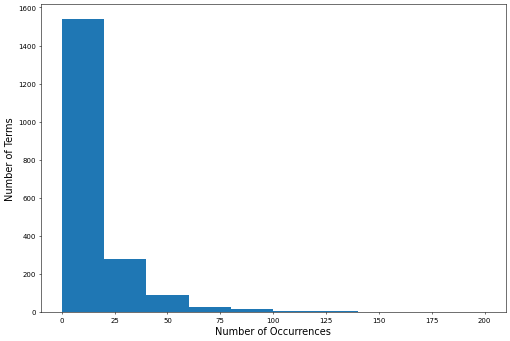

In [78]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [79]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
191    [action, angel, fallen, disappointing, reason,...
192    [angel, fall, mark, time, gerard, butler, secr...
193    [come, time, action, franchise, long, hard, lo...
194    [ric, roman, waugh, angel, fallen, secret, ser...
195    [hollywood, ridiculous, franchise, fallen, ser...
Name: lemmas, dtype: object

## 1.5 Get Lemmatized and Filtered Sentences

In [80]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [81]:
corpus_df.head().T


Doc_ID,191,192,193,194,195
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen,TJH_Doc5_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen,TJH_Doc5_Angelhasfallen
Student Name,TJH,TJH,TJH,TJH,TJH
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...,Ric Roman Waugh's Angel Has Fallen sees U.S. S...,Hollywood's most ridiculous franchise has been...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193,Action_Angel has fallen_N_194,Action_Angel has fallen_N_195
Doc_ID,191,192,193,194,195
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...,[Ric Roman Waugh's Angel Has Fallen sees U.S. ...,[Hollywood's most ridiculous franchise has bee...


## 1.6 Review by Movie

In [82]:
print(corpus_df['Movie Title'].unique())


['Angel has fallen' 'Inception' 'No time to Die' 'Taken' 'Top Gun'
 'Despicable Me 3' 'Holmes and Watson' 'Lost City' 'The Other Guys'
 'Drag me to hell' 'Fresh' 'It Chapter Two' 'Sinister' 'Us' 'Batman'
 'Equilibrium' 'Minority Report' 'Oblivion' 'Pitch Black']


In [83]:
movie_of_interest = 'Batman'

movie_df = corpus_df[corpus_df['Movie Title'] == movie_of_interest].copy()
movie_df.head(3).T

Doc_ID,281,282,283
DSI_Title,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Submission File Name,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Student Name,JWG,JWG,JWG
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Batman,Batman,Batman
Text,How many Batmen does the world need? This may ...,One thing you can say about THE BATMAN without...,"Somewhere inside *The Batman* there's a taut, ..."
Descriptor,Sci-Fi_Batman_N_281,Sci-Fi_Batman_N_282,Sci-Fi_Batman_N_283
Doc_ID,281,282,283
raw_sentences,"[How many Batmen does the world need?, This ma...",[One thing you can say about THE BATMAN withou...,"[Somewhere inside *, The Batman* there's a tau..."


# 2. Knowledge Graph Work

In [84]:
movie_of_interest = 'Batman'

movie_df = corpus_df[corpus_df['Movie Title'] == movie_of_interest].copy()
movie_df.head(3).T

Doc_ID,281,282,283
DSI_Title,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Submission File Name,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Student Name,JWG,JWG,JWG
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Batman,Batman,Batman
Text,How many Batmen does the world need? This may ...,One thing you can say about THE BATMAN without...,"Somewhere inside *The Batman* there's a taut, ..."
Descriptor,Sci-Fi_Batman_N_281,Sci-Fi_Batman_N_282,Sci-Fi_Batman_N_283
Doc_ID,281,282,283
raw_sentences,"[How many Batmen does the world need?, This ma...",[One thing you can say about THE BATMAN withou...,"[Somewhere inside *, The Batman* there's a tau..."


In [85]:
orig_corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
corpus_text_sentences = [y for x in movie_df.sentences_lemmatized for y in x]

example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'change tim batman'

In [86]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]


100%|██████████| 234/234 [00:01<00:00, 154.30it/s]


In [87]:
entity_pairs

[['world', ''],
 ['', ''],
 ['answer', ''],
 ['', ''],
 ['', 'decade movie star'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['sequel batman', ''],
 ['', 'danny good danny jack'],
 ['random screenplay hope explosion', 'audience'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['office legacy superhero', 'batman'],
 ['knight dark dark knight knight', 'franchise post era'],
 ['batman hero darkness', 'aware humor nolan tone'],
 ['nolan trilogy', ''],
 ['', 'emotional  effort'],
 ['time dark knight rise conclusion', ''],
 ['large dc universe', 'sequel reboot'],
 ['nolan billion way studio batman', ''],
 ['', ''],
 ['', 'corporate spend day news'],
 ['', ''],
 ['robert pattinson', ''],
 ['thing  batman', ''],
 ['plot trilogy concern', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['familiar wayne story', 'murder parent gun'],
 ['dark flick knight', 'flick bat'],
 ['paul surveillance mitchell', 'available medium gotham city'],
 ['hunt riddler', 'batman sort control'],
 ['', 'good  friend'],
 ['', ''],
 ['vigilante  ca

In [88]:
print(type(entity_pairs))

<class 'list'>


In [89]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'edge': relations, 'target': target})

In [90]:
kg_df.head(20)

,source,edge,target
0,world,need,
1,,era,
2,answer,consider,
3,,case,
4,,follow,decade movie star
5,,change,
6,,surprise,
7,,follow,
8,sequel batman,fly,
9,,miss,danny good danny jack


## 2.2 Prep Data for Knowledge Graphing

In [91]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [92]:
kg_df.head(20)

,source,edge,target
10,random screenplay hope explosion,distract,audience
14,office legacy superhero,mean,batman
15,knight dark dark knight knight,fail,franchise post era
16,batman hero darkness,use,aware humor nolan tone
20,large dc universe,end,sequel reboot
31,familiar wayne story,know,murder parent gun
32,dark flick knight,need,flick bat
33,paul surveillance mitchell,run,available medium gotham city
34,hunt riddler,lead,batman sort control
44,system,provide,visual provide system


In [93]:
kg_df.head(6).T


,10,14,15,16,20,31
source,random screenplay hope explosion,office legacy superhero,knight dark dark knight knight,batman hero darkness,large dc universe,familiar wayne story
edge,distract,mean,fail,use,end,know
target,audience,batman,franchise post era,aware humor nolan tone,sequel reboot,murder parent gun


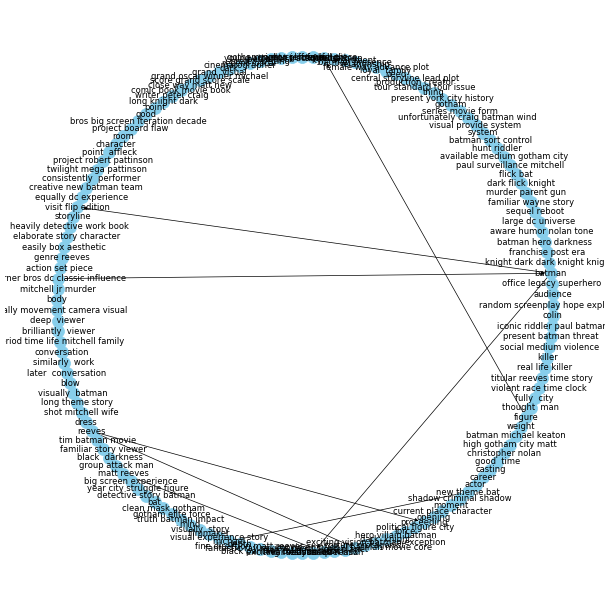

In [94]:
plot_graph(kg_df, use_circular=True)


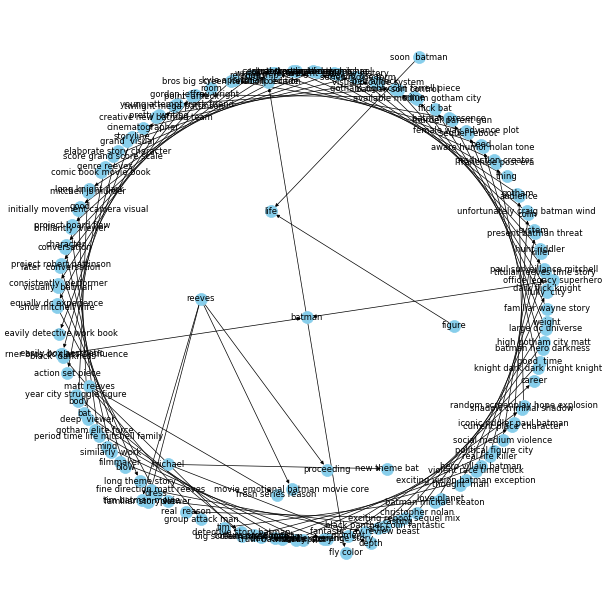

In [95]:
plot_graph(kg_df, use_circular=False)


In [96]:
kg_df['edge'].value_counts()[:50]


leave                3
tell                 3
create               2
reeves               2
establish            2
need                 2
think                2
continue             1
review fantastic     1
thank fine           1
score                1
distract             1
bring fresh          1
care visual          1
prove genuine        1
want                 1
reveal               1
pay                  1
utilize              1
succeed              1
strip                1
thought              1
explore              1
lose                 1
feel like            1
solve elaborate      1
waste                1
emerge               1
help                 1
watch                1
introduce            1
pattinson present    1
dress like           1
lay violent          1
deliver              1
lurk present         1
play                 1
pack visual          1
note                 1
come light           1
fail                 1
use                  1
end                  1
know       

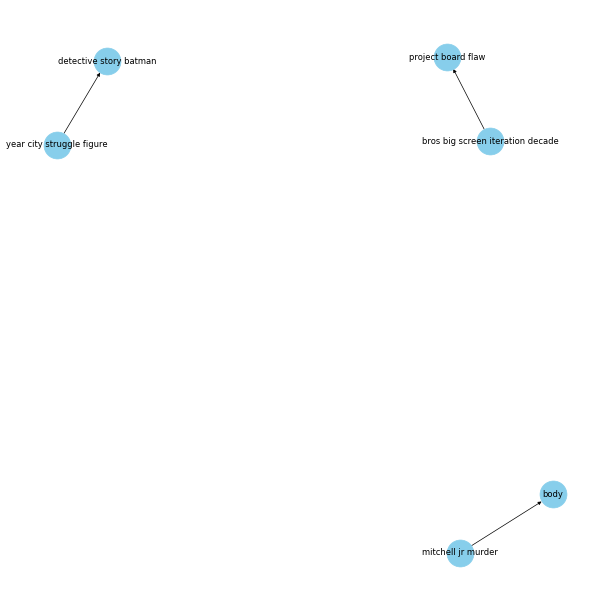

In [97]:
RELATION_TO_EXPLORE = 'tell'
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [98]:
kg_df['target'].value_counts()[:50]


batman                               2
life                                 2
fresh series reason                  1
exciting reboot sequel mix           1
black panther colin fantastic        1
fantastic ray review beast           1
depth                                1
visual experience story              1
visually  story                      1
truth batman impact                  1
clean mask gotham                    1
detective story batman               1
big screen experience                1
group attack man                     1
familiar story viewer                1
tim batman movie                     1
dress                                1
long theme story                     1
blow                                 1
fly color                            1
audience                             1
similarly  work                      1
movie emotional batman movie core    1
present batman threat                1
killer                               1
titular reeves time story

In [99]:
pd.concat([kg_df['source'], kg_df['target']]).value_counts()[:50]


batman                              4
reeves                              4
matt reeves                         2
michael                             2
life                                2
equally dc experience               1
project board flaw                  1
character                           1
project robert pattinson            1
consistently  performer             1
random screenplay hope explosion    1
visit flip edition                  1
long knight dark                    1
heavily detective work book         1
easily box aesthetic                1
action set piece                    1
body                                1
deep  viewer                        1
good                                1
comic book movie book               1
similarly  work                     1
score grand score scale             1
available medium gotham city        1
batman sort control                 1
visual provide system               1
series movie form                   1
present york

In [100]:
find_sources_and_targets_with_patterns(['reeves'], kg_df)

,source,edge,target
85,close way matt new,reeves,comic book movie book
108,genre reeves,embrace,action set piece
118,brilliantly viewer,reeves,period time life mitchell family
125,reeves,utilize,tim batman movie
127,reeves,pay,familiar story viewer
135,matt reeves,create,big screen experience
162,fine direction matt reeves,thank fine,fantastic ray review beast
167,matt reeves,bring fresh,fresh series reason
177,reeves,strip,movie emotional batman movie core
194,reeves,waste,proceeding


In [101]:
find_sources_and_targets_with_patterns(['leave'], kg_df)

,source,edge,target
95,point affleck,leave,project robert pattinson
210,actor,leave,career
221,figure,leave,life


In [102]:
print(kg_df[kg_df['edge'] == "'s"])

Empty DataFrame
Columns: [source, edge, target]
Index: []


In [103]:
print(corpus_text_sentences[43])

close apartment discover question address director cut


In [104]:
rows = [95, 210, 221]
for row in rows:
  print(orig_corpus_text_sentences[row])

At some point, Affleck left the project and Robert Pattinson was tapped to strap on the utility belt.
The actor left behind the tentpoles to have a career on the fringes.
This is not the Batman that cinema-goers are used to-he is not as sure-footed in his humanity as previous adaptations, nor is he ready to embrace having genuine connections with anyone in his orbit-even Alfred Pennyworth (**Andy** **Serkis**), the only father figure left in his life.


# 3. RNN for Predicting Sentiment and Genre

## 3.0 Prep Data

In [105]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Student Name,TJH,TJH,TJH,TJH
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...,Ric Roman Waugh's Angel Has Fallen sees U.S. S...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193,Action_Angel has fallen_N_194
Doc_ID,191,192,193,194
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...,[Ric Roman Waugh's Angel Has Fallen sees U.S. ...


In [106]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))
datafull.head(4).T

,0,1,2,3
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Student Name,TJH,TJH,TJH,TJH
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen `` mark third time Gerard ...,There come time every action franchise take lo...,Ric Roman Waugh 's Angel Has Fallen see U.S. S...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193,Action_Angel has fallen_N_194
Doc_ID,191,192,193,194
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...,[Ric Roman Waugh's Angel Has Fallen sees U.S. ...


In [107]:
data = datafull[['Text','Genre of Movie', 'Review Type (pos or neg)']].copy()

data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes

data['Sentiment'] = data['Review Type (pos or neg)'].apply(lambda x: 1 if x == 'Positive' else 0)

data.tail().T

,185,186,187,188,189
Text,I n't like lament changing tide cinematic land...,"When Pitch Black first hit theater , I immedia...","It 's Vin Diesel week ! Suddenly , largely unk...",Pitch Black sci-fi/horror flick merchant vesse...,A passenger spaceship hit rogue asteroid comet...
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Positive,Positive,Positive,Positive,Positive
Genre of Movie code,3,3,3,3,3
Sentiment,1,1,1,1,1


In [108]:
features, targets = data['Text'], data['Genre of Movie code']                                                                         
data[["Genre of Movie","Genre of Movie code", 'Sentiment']].value_counts()

Genre of Movie  Genre of Movie code  Sentiment
Action          0                    0            25
                                     1            25
Horror          2                    0            25
                                     1            25
Sci-Fi          3                    0            25
                                     1            25
Comedy          1                    0            20
                                     1            20
dtype: int64

### 3.0.3 Split Train/Test/Val

In [109]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code', 'Sentiment']])
trainds.shape, valds.shape, testds.shape

((152, 3), (19, 3), (19, 3))

### 3.0.4 Convert to Tensorflows

In [110]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
train_sen_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Sentiment'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
test_sen_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Sentiment'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)
val_sen_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Sentiment'].values, tf.int64),
)

### 3.0.6 Create Modeling Datasets

In [111]:
train_ds_cat = tf.data.Dataset.zip((train_text_ds_raw, train_cat_ds_raw))
train_ds_sen = tf.data.Dataset.zip((train_text_ds_raw, train_sen_ds_raw))

test_ds_cat = tf.data.Dataset.zip((test_text_ds_raw, test_cat_ds_raw))
test_ds_sen = tf.data.Dataset.zip((test_text_ds_raw, test_sen_ds_raw))

val_ds_cat = tf.data.Dataset.zip((val_text_ds_raw, val_cat_ds_raw))
val_ds_sen = tf.data.Dataset.zip((val_text_ds_raw, val_sen_ds_raw))

### 3.0.7 Create Pipelines

In [112]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds_cat.cardinality().numpy()

train_ds_cat = train_ds_cat.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

train_ds_sen = train_ds_sen.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds_cat = test_ds_cat.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds_sen = test_ds_sen.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

val_ds_cat = val_ds_cat.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

val_ds_sen = val_ds_sen.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

## 3.1 Create Encoder

In [113]:
VOCAB_SIZE=5000
encoder_5000 = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder_5000.adapt(train_ds_cat.map(lambda text, label: text), batch_size= None)

In [114]:
VOCAB_SIZE=7000
encoder_7000 = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder_7000.adapt(train_ds_cat.map(lambda text, label: text), batch_size= None)

In [115]:
vocab_5000 = np.array(encoder_5000.get_vocabulary())
len(vocab_5000)

5000

In [116]:
vocab = np.array(encoder_5000.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'movie', 'nt', 'i', 'one', 'like',
       'it', 'time', 'but', 'character', 'even', 'get', 'also', 'make',
       'way', 'story'], dtype='<U70')

In [117]:
vocab[-20:]

array(['voracious', 'vomiting', 'volleyball', 'vogue', 'vocabulary',
       'vivid', 'vitality', 'visualeffects', 'vista', 'visitor',
       'visited', 'visitation', 'visibly', 'visceral', 'virus',
       'virtually', 'virginity', 'virginal', 'viper', 'violin'],
      dtype='<U70')

In [118]:
encoded_example = encoder_5000('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([  1, 143,   1, 646,   1,   1, 193, 193])

In [119]:
for example, label in train_ds_cat.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"In review `` It `` 2017 , I clearly stated I liked setting event taking place term location time . I also explained I liked character , plot message film much . However , I recorded reservation sequence event classification film inside world horror . For It Chapter 2 I 'm afraid I 'm gon na move everything reservation box , maybe slight exception horror unexpected utilisation comedy . 27 year event It chapter 1 , monster awakens . Pennywise clown reappears get detected Mike ; The member loser club actually remained Derry , sole purpose studying terminate Pennywise alarm others soon appears . Mike contact rest gang come back honor oath , time Pennywise much stronger prepared challenge loser . Chapter 2 described messy get organized go back worst mess I imagine . We start event character never see throughout entire film . Then spend lot time struggle decision , everybody , including character , knew conclusion , finally horror begin . Oh yeah , get see real horror second half 

## 3.2 Category Modeling

We're going to permute:

* S1 or S2: Two model structures.  64 --> 32 and 128-->64-->32
* V1 or V2: Size of vocabulary embedded.  5k vs 7k
* D1 or D2: Two dropout values.  30% and 50%

Models will be encoded as cat_SVD, e.g., cat_111 for the first of all

### 3.2.0 Setup

In [120]:
num_classes = 4
model_cat = 'Model Cat'

train_ds = train_ds_cat
test_ds = test_ds_cat
val_ds = val_ds_cat

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']


### 3.2.1 Cat_111

In [121]:
%%time
run = True

model_code = '111'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  cat111=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat111

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 58s 786ms/step - loss: 1.3862 - accuracy: 0.2800 - val_loss: 1.3661 - val_accuracy: 0.2222
Epoch 2/200
50/50 [==============================] - 33s 659ms/step - loss: 1.2445 - accuracy: 0.4400 - val_loss: 1.1499 - val_accuracy: 0.4444
Epoch 3/200
50/50 [==============================] - 32s 651ms/step - loss: 1.1392 - accuracy: 0.6400 - val_loss: 1.2705 - val_accuracy: 0.5556
Epoch 4/200
50/50 [==============================] - 32s 651ms/step - loss: 0.5463 - accuracy: 0.8067 - val_loss: 0.7947 - val_accuracy: 0.6667
Epoch 5/200
50/50 [==============================] - 33s 654ms/step - loss: 0.1403 - accuracy: 0.9600 - val_loss: 0.5598 - val_accuracy: 0.8889
Epoch 6/200
50/50 [==============================] - 33s 654ms/step - loss: 0.0737 - accuracy: 0.9933 - val_loss: 1.0232 - val_accuracy: 0.5556
Epoch 7/200
50/50 [==============================] - 33s 662ms/step - loss: 0.0498 - accuracy: 0.9867 - val_loss: 2.4106 - val_accuracy:

In [122]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [123]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 102ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat111')

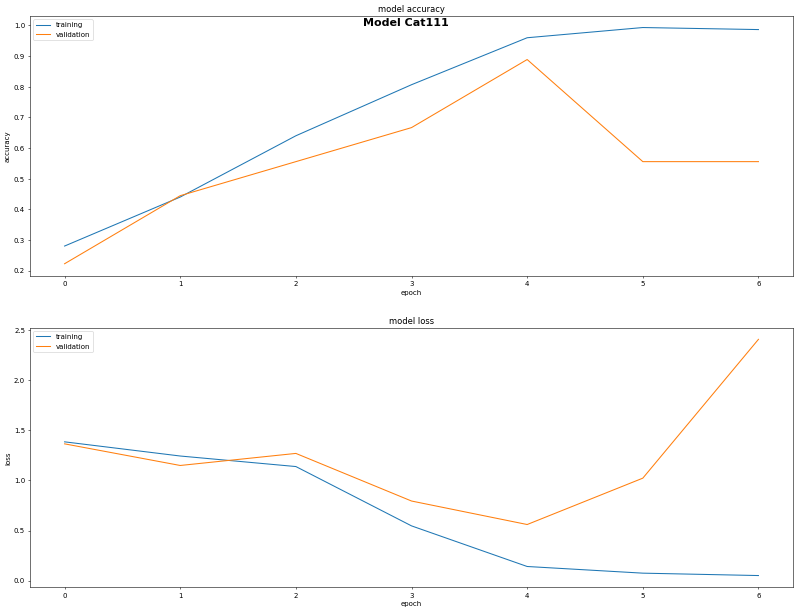

In [124]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 7s 93ms/step


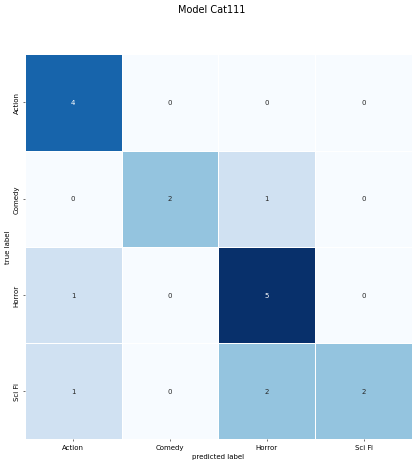

In [125]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_112

In [126]:
%%time
run = False

model_code = '112'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  cat112=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat112

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 57s 797ms/step - loss: 1.3885 - accuracy: 0.2000 - val_loss: 1.3950 - val_accuracy: 0.3333
Epoch 2/200
50/50 [==============================] - 33s 653ms/step - loss: 1.4009 - accuracy: 0.4133 - val_loss: 1.6362 - val_accuracy: 0.3333
Epoch 3/200
50/50 [==============================] - 33s 654ms/step - loss: 1.3330 - accuracy: 0.3133 - val_loss: 1.2188 - val_accuracy: 0.3333
CPU times: user 3min 9s, sys: 1.57 s, total: 3min 10s
Wall time: 2min 14s


In [127]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [128]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 92ms/step - loss: 1.2862 - accuracy: 0.2778
Test Loss: 1.286192536354065
Test Accuracy: 0.2777777910232544


Text(0.5, 0.98, 'Model Cat112')

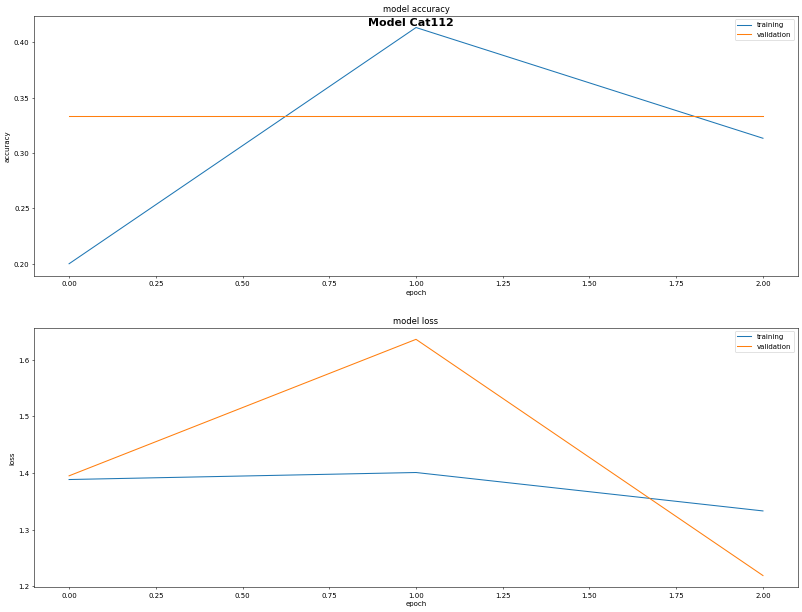

In [129]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 6s 153ms/step


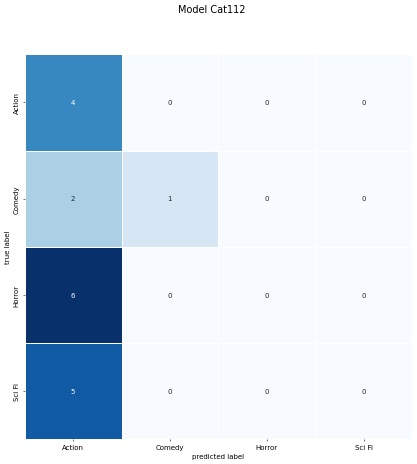

In [130]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Cat_121

In [131]:
%%time
run = False

model_code = '121'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  cat121=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat121

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 56s 786ms/step - loss: 1.3863 - accuracy: 0.2733 - val_loss: 1.3756 - val_accuracy: 0.2222
Epoch 2/200
50/50 [==============================] - 33s 652ms/step - loss: 1.2246 - accuracy: 0.5400 - val_loss: 1.6220 - val_accuracy: 0.3333
Epoch 3/200
50/50 [==============================] - 33s 658ms/step - loss: 0.9266 - accuracy: 0.6333 - val_loss: 1.0486 - val_accuracy: 0.4444
Epoch 4/200
50/50 [==============================] - 33s 655ms/step - loss: 0.2987 - accuracy: 0.9600 - val_loss: 1.1646 - val_accuracy: 0.4444
Epoch 5/200
50/50 [==============================] - 35s 696ms/step - loss: 0.0504 - accuracy: 1.0000 - val_loss: 1.4828 - val_accuracy: 0.5556
Epoch 6/200
50/50 [==============================] - 33s 664ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.7450 - val_accuracy: 0.6667
Epoch 7/200
50/50 [==============================] - 33s 654ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.1471 - val_accuracy:

In [132]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          448000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [133]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 93ms/step - loss: 0.8603 - accuracy: 0.7222
Test Loss: 0.8603388071060181
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat121')

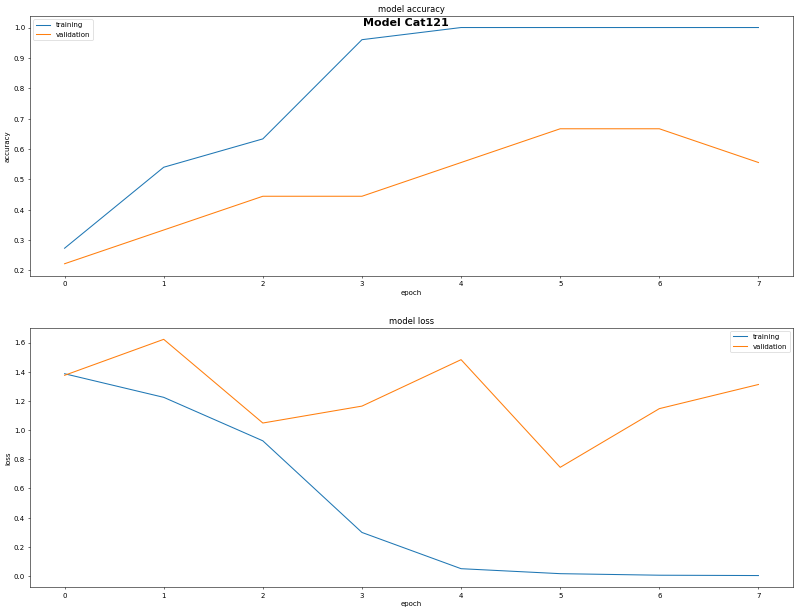

In [134]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 6s 155ms/step


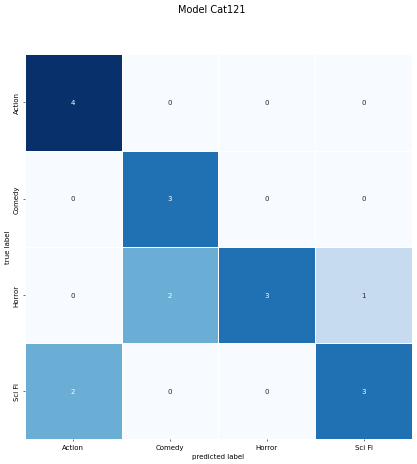

In [135]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_122

In [136]:
%%time
run = False

model_code = '122'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  cat122=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat122

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 57s 787ms/step - loss: 1.3852 - accuracy: 0.2733 - val_loss: 1.4416 - val_accuracy: 0.1111
Epoch 2/200
50/50 [==============================] - 32s 650ms/step - loss: 1.3538 - accuracy: 0.3600 - val_loss: 1.2888 - val_accuracy: 0.6667
Epoch 3/200
50/50 [==============================] - 33s 653ms/step - loss: 1.1108 - accuracy: 0.5867 - val_loss: 0.9084 - val_accuracy: 0.7778
Epoch 4/200
50/50 [==============================] - 33s 661ms/step - loss: 0.5088 - accuracy: 0.8333 - val_loss: 1.0465 - val_accuracy: 0.4444
Epoch 5/200
50/50 [==============================] - 33s 653ms/step - loss: 0.2483 - accuracy: 0.9267 - val_loss: 1.0465 - val_accuracy: 0.6667
CPU times: user 4min 58s, sys: 2.12 s, total: 5min
Wall time: 3min 28s


In [137]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          448000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [138]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 104ms/step - loss: 1.0959 - accuracy: 0.6111
Test Loss: 1.095866084098816
Test Accuracy: 0.6111111044883728


Text(0.5, 0.98, 'Model Cat122')

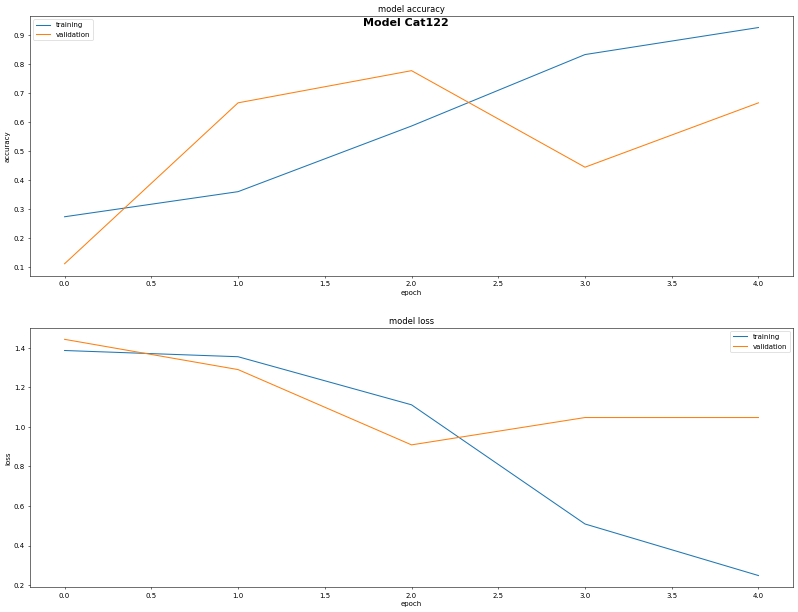

In [139]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 7s 162ms/step


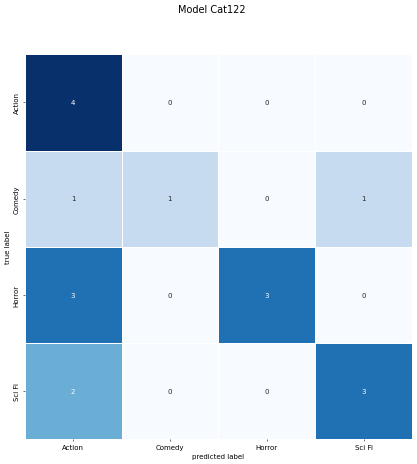

In [140]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Cat_211

In [141]:
%%time
run = False

model_code = '211'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  cat211=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat211

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 99s 1s/step - loss: 1.3866 - accuracy: 0.2333 - val_loss: 1.3897 - val_accuracy: 0.2222
Epoch 2/200
50/50 [==============================] - 63s 1s/step - loss: 1.0868 - accuracy: 0.5067 - val_loss: 1.4807 - val_accuracy: 0.2222
Epoch 3/200
50/50 [==============================] - 64s 1s/step - loss: 0.5624 - accuracy: 0.8267 - val_loss: 0.9447 - val_accuracy: 0.5556
Epoch 4/200
50/50 [==============================] - 65s 1s/step - loss: 0.1593 - accuracy: 0.9667 - val_loss: 1.7415 - val_accuracy: 0.4444
Epoch 5/200
50/50 [==============================] - 63s 1s/step - loss: 0.0486 - accuracy: 0.9800 - val_loss: 1.5009 - val_accuracy: 0.5556
CPU times: user 9min 36s, sys: 3.16 s, total: 9min 40s
Wall time: 6min 45s


In [142]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [143]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 232ms/step - loss: 0.5719 - accuracy: 0.7222
Test Loss: 0.5719113945960999
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat211')

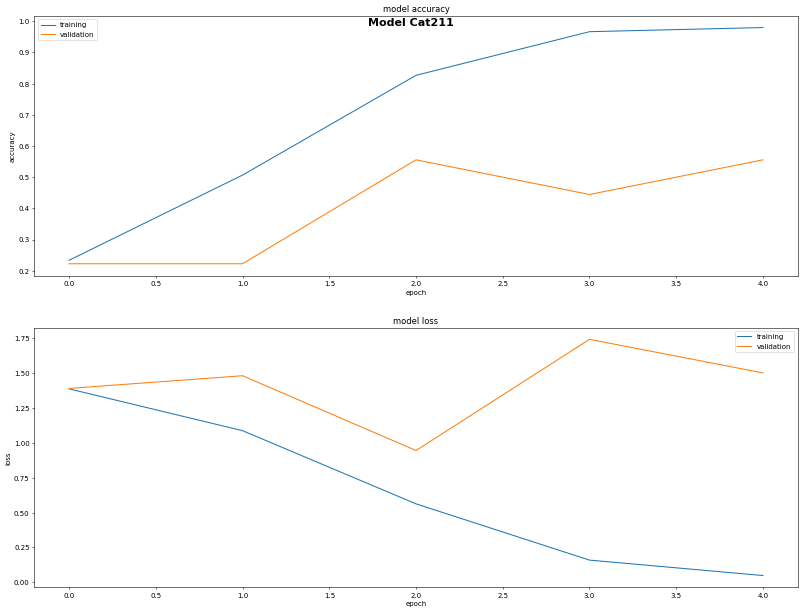

In [144]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 12s 212ms/step


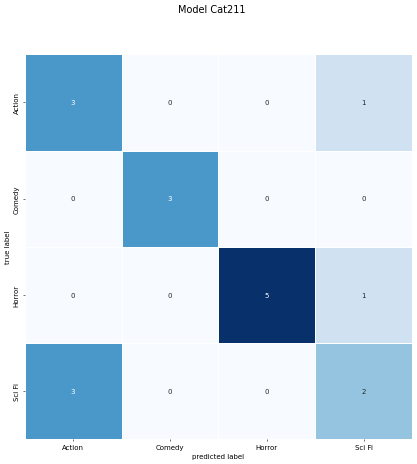

In [145]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_212

In [146]:
%%time
run = False

model_code = '212'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  cat212=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat212

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 99s 1s/step - loss: 1.3909 - accuracy: 0.2400 - val_loss: 1.3828 - val_accuracy: 0.3333
Epoch 2/200
50/50 [==============================] - 63s 1s/step - loss: 1.3456 - accuracy: 0.3467 - val_loss: 1.3562 - val_accuracy: 0.2222
Epoch 3/200
50/50 [==============================] - 63s 1s/step - loss: 0.9926 - accuracy: 0.5200 - val_loss: 1.9218 - val_accuracy: 0.2222
CPU times: user 6min, sys: 2.19 s, total: 6min 3s
Wall time: 4min 17s


In [147]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [148]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 174ms/step - loss: 1.3891 - accuracy: 0.4444
Test Loss: 1.3891428709030151
Test Accuracy: 0.4444444477558136


Text(0.5, 0.98, 'Model Cat212')

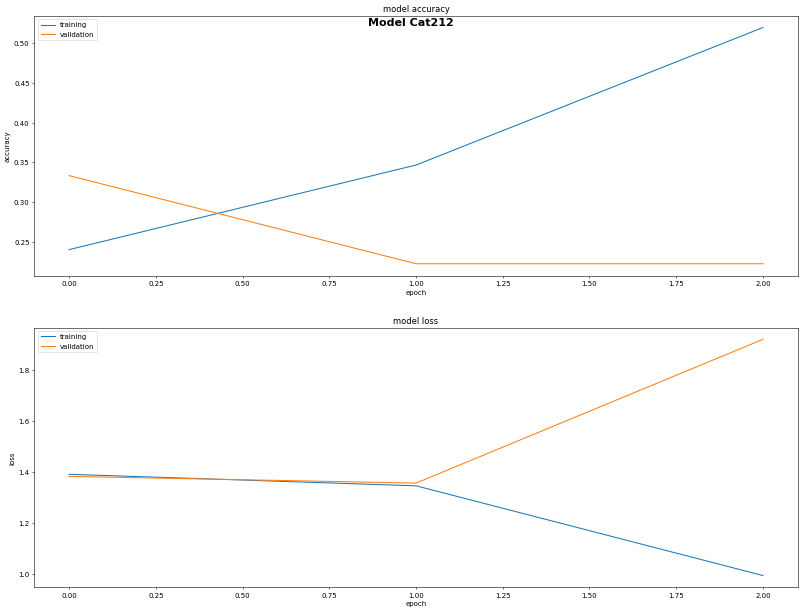

In [149]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 9s 162ms/step


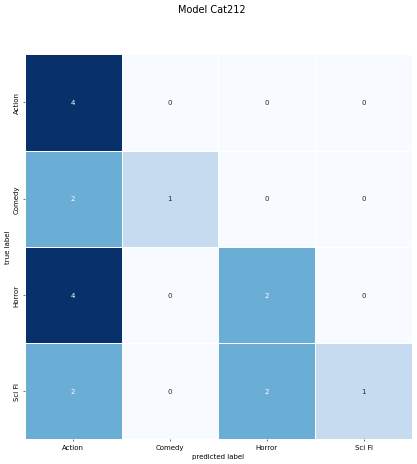

In [150]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Cat_221

In [151]:
%%time
run = False

model_code = '221'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  cat221=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat221

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 100s 1s/step - loss: 1.3882 - accuracy: 0.2467 - val_loss: 1.3853 - val_accuracy: 0.5556
Epoch 2/200
50/50 [==============================] - 65s 1s/step - loss: 1.0921 - accuracy: 0.5867 - val_loss: 1.9665 - val_accuracy: 0.0000e+00
Epoch 3/200
50/50 [==============================] - 63s 1s/step - loss: 0.5605 - accuracy: 0.8200 - val_loss: 1.2891 - val_accuracy: 0.6667
Epoch 4/200
50/50 [==============================] - 65s 1s/step - loss: 0.3057 - accuracy: 0.8800 - val_loss: 2.5094 - val_accuracy: 0.3333
Epoch 5/200
50/50 [==============================] - 63s 1s/step - loss: 0.1541 - accuracy: 0.9600 - val_loss: 0.9967 - val_accuracy: 0.7778
Epoch 6/200
50/50 [==============================] - 63s 1s/step - loss: 0.0547 - accuracy: 0.9800 - val_loss: 1.1723 - val_accuracy: 0.7778
Epoch 7/200
50/50 [==============================] - 63s 1s/step - loss: 0.0726 - accuracy: 0.9733 - val_loss: 2.3545 - val_accuracy: 0.4444
CPU time

In [152]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         896000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [153]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 173ms/step - loss: 0.9094 - accuracy: 0.8333
Test Loss: 0.9093573093414307
Test Accuracy: 0.8333333134651184


Text(0.5, 0.98, 'Model Cat221')

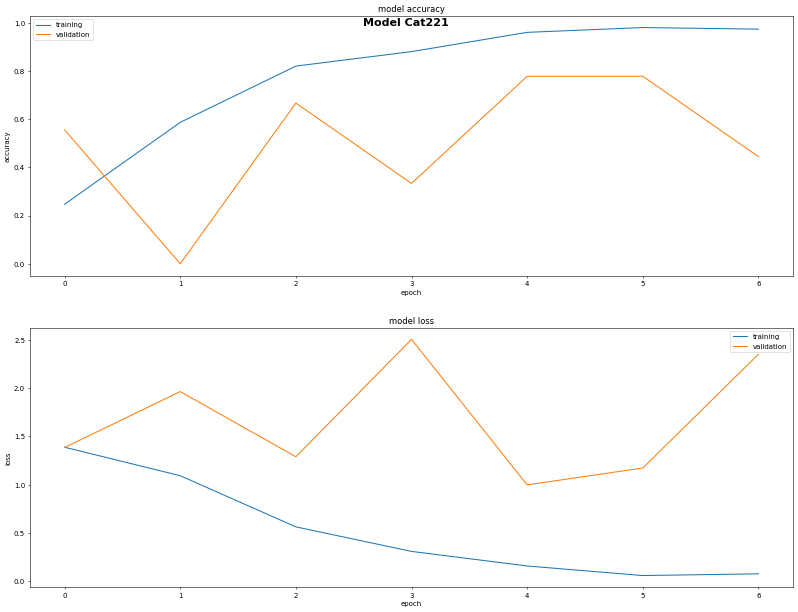

In [154]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 10s 168ms/step


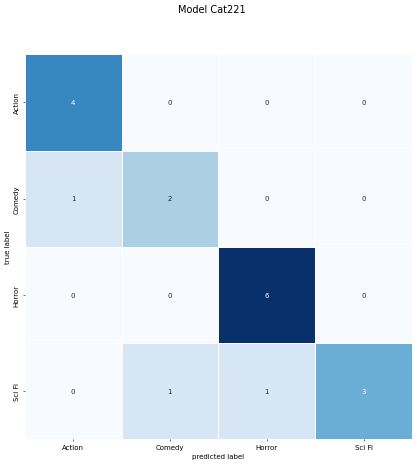

In [155]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_222

In [156]:
%%time
run = True

model_code = '222'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  cat212=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat222

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

NameError: ignored

In [157]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         896000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [158]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 3s 161ms/step - loss: 0.9094 - accuracy: 0.8333
Test Loss: 0.9093573093414307
Test Accuracy: 0.8333333134651184


Text(0.5, 0.98, 'Model Cat222')

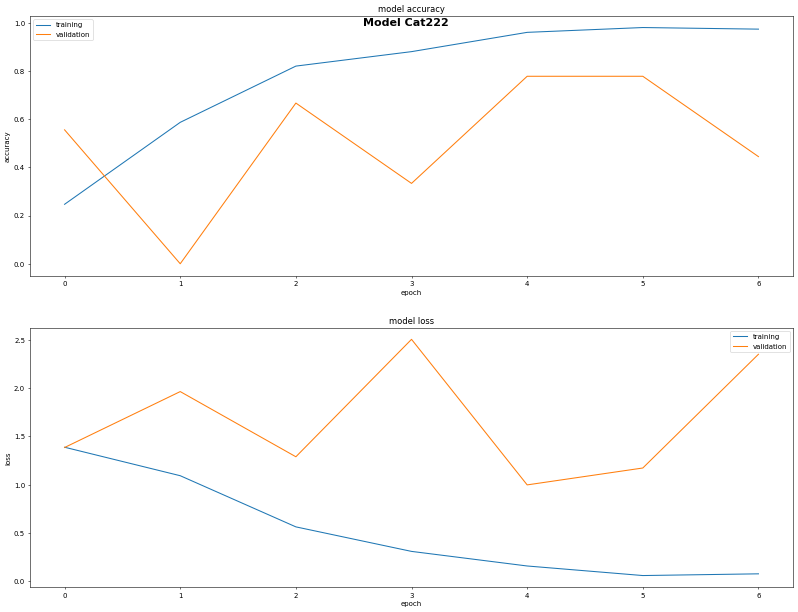

In [159]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 2s 161ms/step


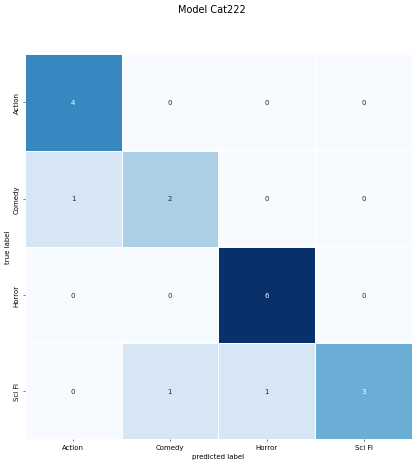

In [160]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

## 3.3 Sentiment Modeling

We're going to permute:

* S1 or S2: Two model structures.  64 --> 32 and 128-->64-->32
* V1 or V2: Size of vocabulary embedded.  5k vs 7k
* D1 or D2: Two dropout values.  30% and 50%

Models will be encoded as sen_SVD, e.g., cat_111 for the first of all

# 3.3.0 Setup

In [161]:
num_classes = 2
model_cat = 'Model Sen'

train_ds = train_ds_sen
test_ds = test_ds_sen
val_ds = val_ds_sen

CLASSES_LIST = ['Neg', 'Pos']


### 3.2.1 Sen_111

In [162]:
%%time
run = False

model_code = '111'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  sen111=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen111

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 60s 780ms/step - loss: 0.6961 - accuracy: 0.4467 - val_loss: 0.6941 - val_accuracy: 0.4444
Epoch 2/200
50/50 [==============================] - 33s 654ms/step - loss: 0.6158 - accuracy: 0.6800 - val_loss: 0.9343 - val_accuracy: 0.3333
Epoch 3/200
50/50 [==============================] - 33s 655ms/step - loss: 0.1496 - accuracy: 0.9467 - val_loss: 2.0285 - val_accuracy: 0.3333
CPU times: user 3min 15s, sys: 1.16 s, total: 3min 16s
Wall time: 2min 19s


In [163]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [164]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 99ms/step - loss: 1.0725 - accuracy: 0.6111
Test Loss: 1.0725349187850952
Test Accuracy: 0.6111111044883728


Text(0.5, 0.98, 'Model Sen111')

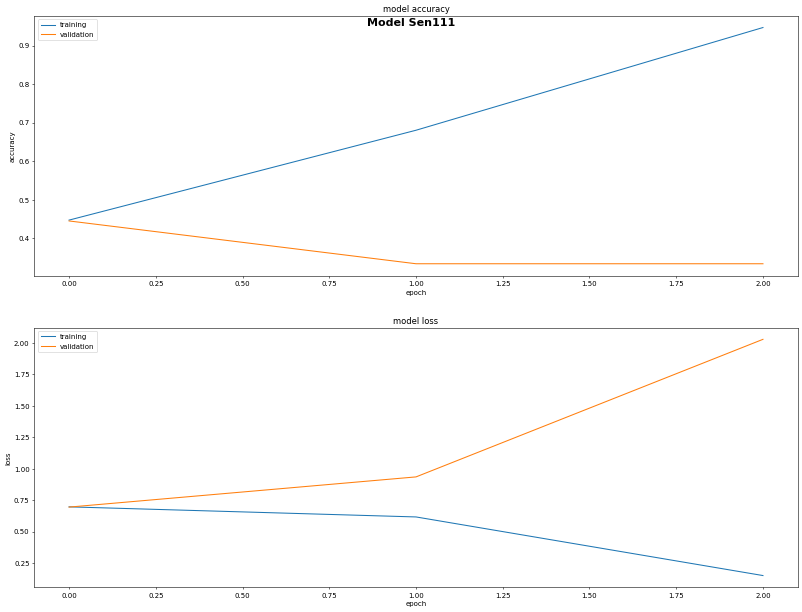

In [165]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 6s 92ms/step


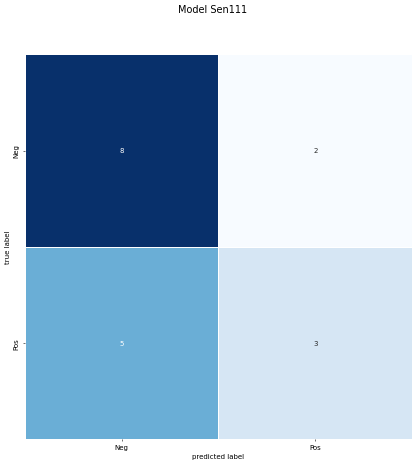

In [166]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.3.2 Sen_112

In [167]:
%%time
run = False

model_code = '112'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  sen112=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen112

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 56s 767ms/step - loss: 0.6964 - accuracy: 0.4800 - val_loss: 0.6952 - val_accuracy: 0.4444
Epoch 2/200
50/50 [==============================] - 34s 688ms/step - loss: 0.7039 - accuracy: 0.5400 - val_loss: 1.1482 - val_accuracy: 0.4444
Epoch 3/200
50/50 [==============================] - 33s 651ms/step - loss: 0.7381 - accuracy: 0.5400 - val_loss: 0.6932 - val_accuracy: 0.5556
Epoch 4/200
50/50 [==============================] - 34s 685ms/step - loss: 0.4502 - accuracy: 0.7800 - val_loss: 1.6786 - val_accuracy: 0.4444
Epoch 5/200
50/50 [==============================] - 33s 651ms/step - loss: 0.0402 - accuracy: 0.9933 - val_loss: 1.3078 - val_accuracy: 0.4444
CPU times: user 4min 58s, sys: 1.18 s, total: 5min
Wall time: 3min 20s


In [168]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [169]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 102ms/step - loss: 1.1773 - accuracy: 0.5556
Test Loss: 1.1772531270980835
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen112')

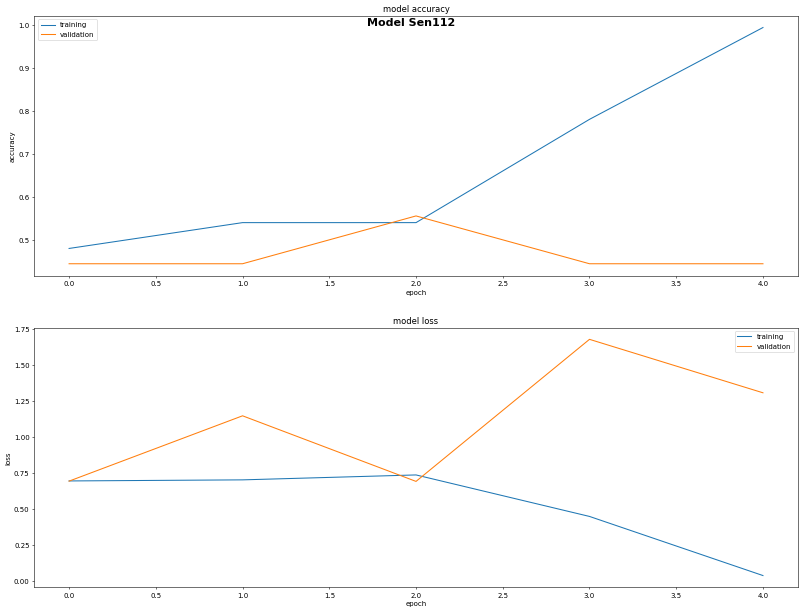

In [170]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 5s 91ms/step


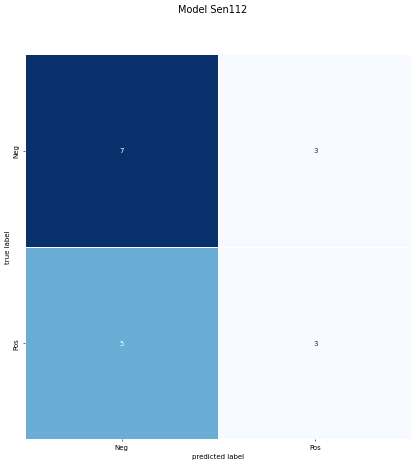

In [171]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Sen_121

In [172]:
%%time
run = False

model_code = '121'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  sen121=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen121

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 61s 843ms/step - loss: 0.6950 - accuracy: 0.4867 - val_loss: 0.6908 - val_accuracy: 0.5556
Epoch 2/200
50/50 [==============================] - 32s 647ms/step - loss: 0.6646 - accuracy: 0.6933 - val_loss: 0.7256 - val_accuracy: 0.4444
Epoch 3/200
50/50 [==============================] - 33s 653ms/step - loss: 0.3263 - accuracy: 0.9267 - val_loss: 1.0511 - val_accuracy: 0.3333
CPU times: user 3min 15s, sys: 1.59 s, total: 3min 16s
Wall time: 2min 57s


In [173]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          448000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [174]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 99ms/step - loss: 0.8585 - accuracy: 0.5556
Test Loss: 0.858526349067688
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen121')

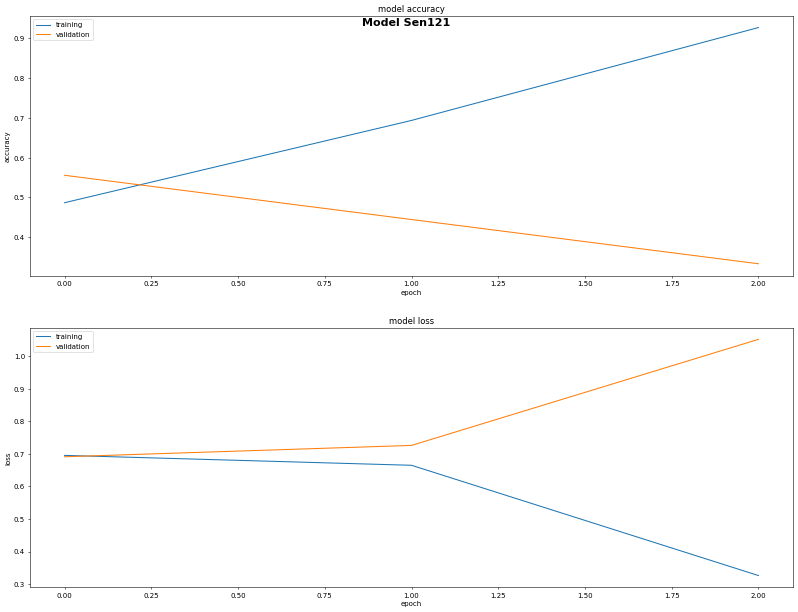

In [175]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 6s 162ms/step


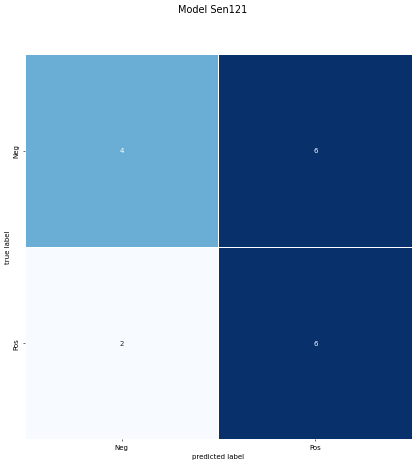

In [176]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Sen_122

In [177]:
%%time
run = False

model_code = '122'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  sen122=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen122

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 57s 804ms/step - loss: 0.6956 - accuracy: 0.4600 - val_loss: 0.7141 - val_accuracy: 0.2222
Epoch 2/200
50/50 [==============================] - 33s 658ms/step - loss: 0.6375 - accuracy: 0.6467 - val_loss: 0.8284 - val_accuracy: 0.3333
Epoch 3/200
50/50 [==============================] - 33s 655ms/step - loss: 0.1669 - accuracy: 0.9400 - val_loss: 1.8802 - val_accuracy: 0.3333
Epoch 4/200
50/50 [==============================] - 33s 667ms/step - loss: 0.0450 - accuracy: 0.9933 - val_loss: 1.8696 - val_accuracy: 0.4444
Epoch 5/200
50/50 [==============================] - 33s 653ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.1700 - val_accuracy: 0.1111
Epoch 6/200
50/50 [==============================] - 35s 691ms/step - loss: 6.2340e-04 - accuracy: 1.0000 - val_loss: 0.8188 - val_accuracy: 0.7778
Epoch 7/200
50/50 [==============================] - 33s 664ms/step - loss: 3.3003e-04 - accuracy: 1.0000 - val_loss: 3.0733 - val_a

In [178]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          448000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [179]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 108ms/step - loss: 1.6119 - accuracy: 0.6111
Test Loss: 1.611938714981079
Test Accuracy: 0.6111111044883728


Text(0.5, 0.98, 'Model Sen122')

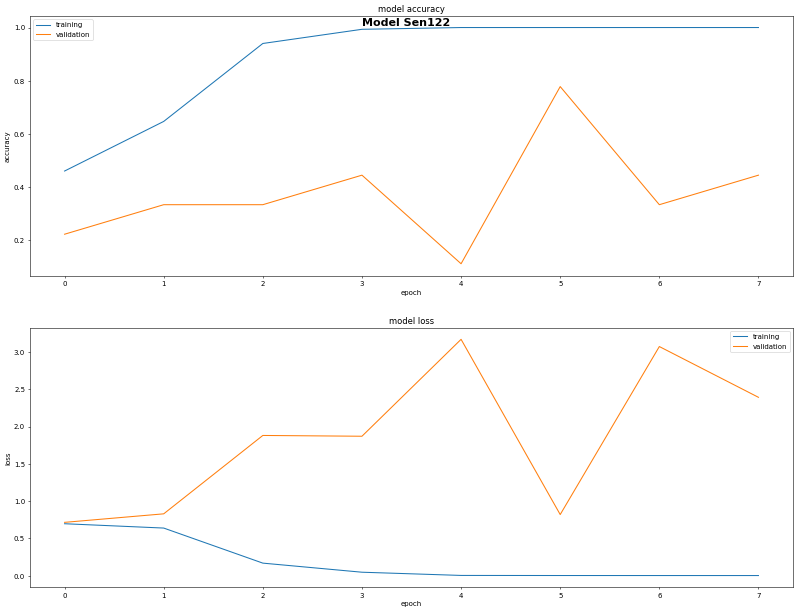

In [180]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 7s 162ms/step


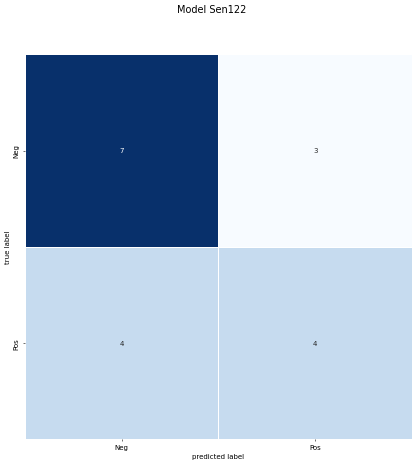

In [181]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Sen_211

In [182]:
%%time
run = False

model_code = '211'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  sen211=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen211

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 99s 1s/step - loss: 0.6977 - accuracy: 0.4400 - val_loss: 0.7250 - val_accuracy: 0.2222
Epoch 2/200
50/50 [==============================] - 64s 1s/step - loss: 0.6851 - accuracy: 0.5733 - val_loss: 0.6396 - val_accuracy: 0.7778
Epoch 3/200
50/50 [==============================] - 66s 1s/step - loss: 0.3954 - accuracy: 0.8200 - val_loss: 2.7601 - val_accuracy: 0.2222
Epoch 4/200
50/50 [==============================] - 64s 1s/step - loss: 0.0368 - accuracy: 0.9933 - val_loss: 3.8755 - val_accuracy: 0.3333
CPU times: user 7min 48s, sys: 3.03 s, total: 7min 51s
Wall time: 5min 24s


In [183]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [184]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 208ms/step - loss: 1.9989 - accuracy: 0.6111
Test Loss: 1.9989111423492432
Test Accuracy: 0.6111111044883728


Text(0.5, 0.98, 'Model Sen211')

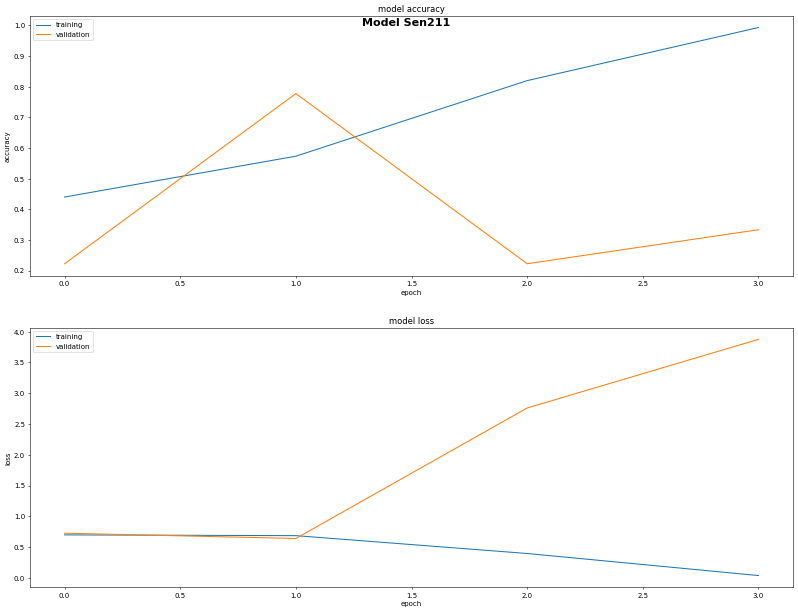

In [185]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 13s 165ms/step


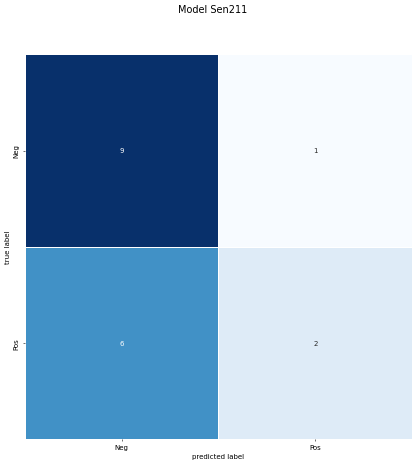

In [186]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Sen_212

In [187]:
%%time
run = False

model_code = '212'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  sen212=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen212

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 100s 1s/step - loss: 0.6968 - accuracy: 0.4533 - val_loss: 0.6975 - val_accuracy: 0.3333
Epoch 2/200
50/50 [==============================] - 66s 1s/step - loss: 0.7015 - accuracy: 0.5600 - val_loss: 0.8987 - val_accuracy: 0.4444
Epoch 3/200
50/50 [==============================] - 64s 1s/step - loss: 0.7405 - accuracy: 0.4733 - val_loss: 0.6967 - val_accuracy: 0.2222
Epoch 4/200
50/50 [==============================] - 64s 1s/step - loss: 0.7119 - accuracy: 0.4933 - val_loss: 0.6970 - val_accuracy: 0.3333
CPU times: user 7min 48s, sys: 2.65 s, total: 7min 51s
Wall time: 5min 17s


In [188]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [189]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 168ms/step - loss: 0.6919 - accuracy: 0.5556
Test Loss: 0.6918904781341553
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen212')

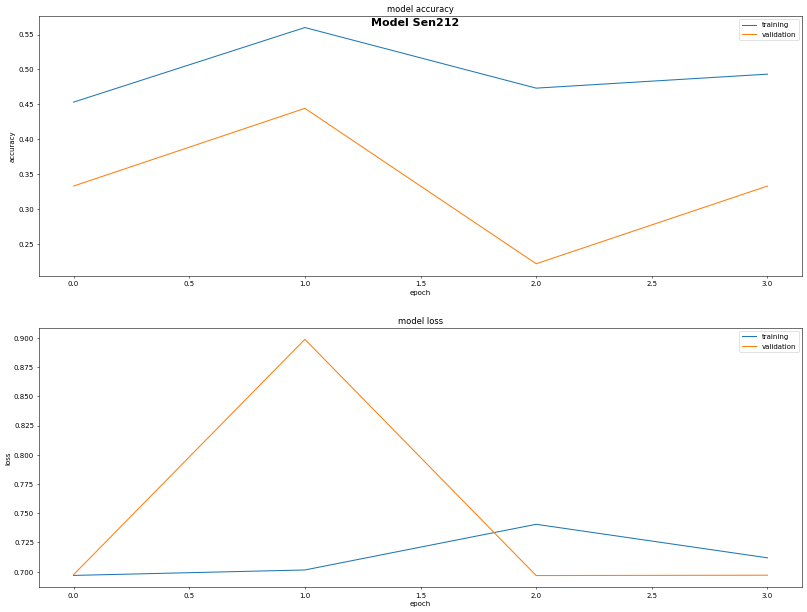

In [190]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 9s 197ms/step


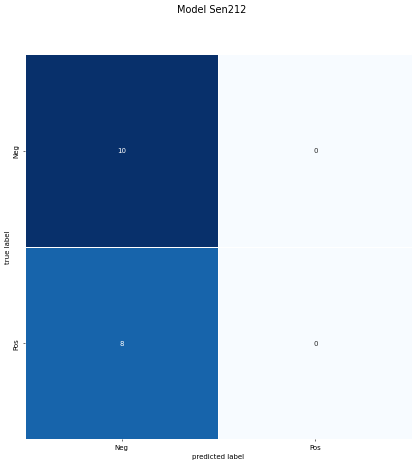

In [191]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Sen_221

In [192]:
%%time
run = True

model_code = '221'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  sen221=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen221

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 100s 1s/step - loss: 0.6971 - accuracy: 0.4533 - val_loss: 0.6955 - val_accuracy: 0.4444
Epoch 2/200
50/50 [==============================] - 65s 1s/step - loss: 0.5282 - accuracy: 0.7733 - val_loss: 1.4383 - val_accuracy: 0.2222
Epoch 3/200
50/50 [==============================] - 64s 1s/step - loss: 0.0245 - accuracy: 0.9933 - val_loss: 2.1390 - val_accuracy: 0.3333
CPU times: user 6min 5s, sys: 2.66 s, total: 6min 7s
Wall time: 4min 13s


In [193]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         896000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [194]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 177ms/step - loss: 1.2870 - accuracy: 0.5556
Test Loss: 1.2869563102722168
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen221')

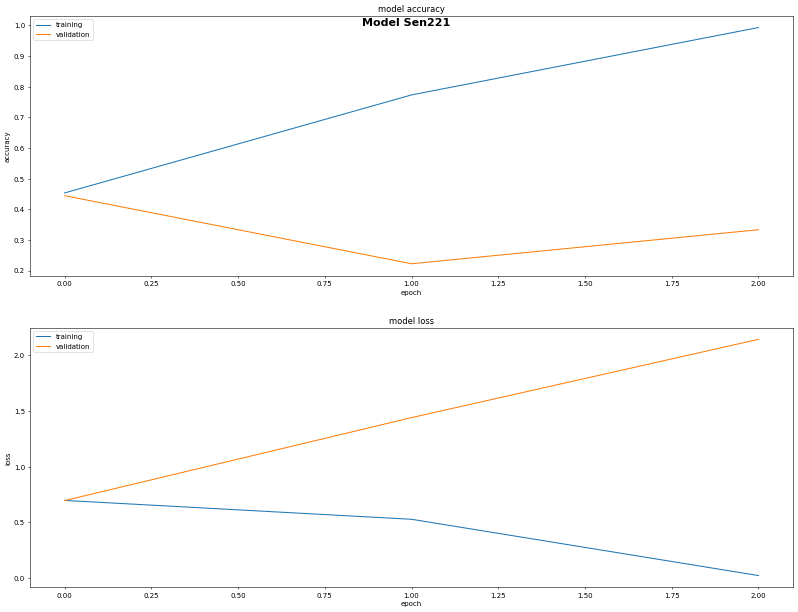

In [195]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 14s 270ms/step


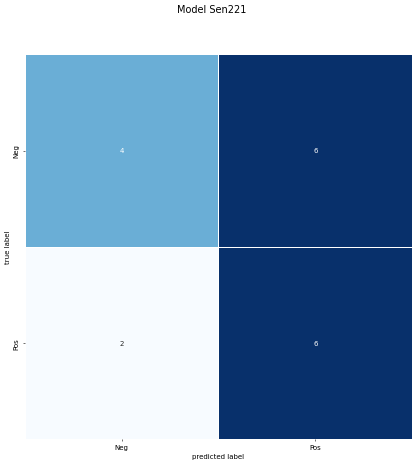

In [196]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Sen_222

In [197]:
%%time
run = True

model_code = '222'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  sen212=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen222

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

NameError: ignored

In [198]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         896000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [199]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 2s 165ms/step - loss: 1.2870 - accuracy: 0.5556
Test Loss: 1.2869563102722168
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen222')

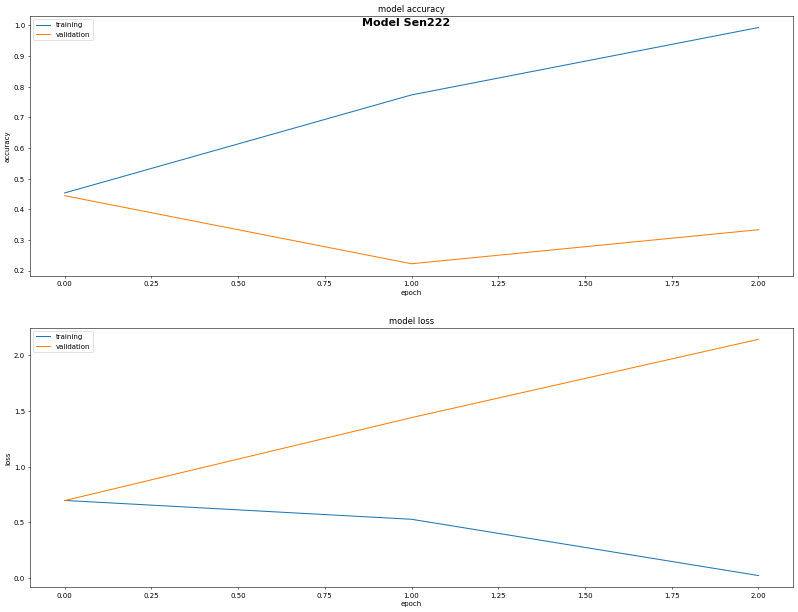

In [200]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 3s 258ms/step


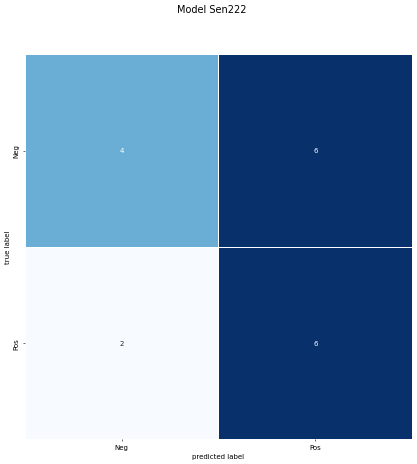

In [201]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)